### MultiBERT

In [2]:
!python3 --version

Python 3.6.9


In [3]:
from os.path import join
from os import listdir

listdir(join('multi_cased_L-12_H-768_A-12'))

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt']

In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs')
writer

In [6]:
from transformers import BertTokenizer, BertModel
import math

MODEL = 'bert-base-multilingual-cased'

tokenizer = BertTokenizer.from_pretrained(MODEL)

texts = [
    'London is the capital of Paris, and Paris is the capital of Rome',
    'Paris est la commune la plus peuplée et la capitale de la France.',
    'Rom ist die Hauptstadt Italiens, Hauptort der Region Latium und historische Hauptstadt des Römischen Reichs und des Kirchenstaats.'
]

# max_length = math.floor(np.mean([len(art.split()) for art in news.data]))

encoded_input = tokenizer(texts, padding=True, truncation=True,
                          # max_length=max_length,
                          return_tensors='pt')

encoded_input['input_ids']

tensor([[   101,  10829,  10124,  10105,  12185,  10108,  10728,    117,  10111,
          10728,  10124,  10105,  12185,  10108,  14592,    102,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0],
        [   101,  10728,  10176,  10109,  11380,  10109,  10563,  14574,  55852,
          11245,  10131,  10109,  19968,  10104,  10109,  10688,    119,    102,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0],
        [   101,  21239,  10298,  10128,  36631,  94883,    117, 101099,  10118,
          13919,  10159,  53281,  10130,  34576,  36631,  10139,    155,  14902,
         105874,  19396,  10107,  10130,  10139,  47346,  58922,  10107,    119,
            102]])

In [7]:
encoded_input['input_ids'].shape

torch.Size([3, 28])

In [8]:
import torch

model = BertModel.from_pretrained(MODEL, output_hidden_states=False, output_attentions=True)
# writer.add_graph(model)
model.eval()

with torch.no_grad():
    output = model(**encoded_input)

output.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'attentions'])

### Visualization

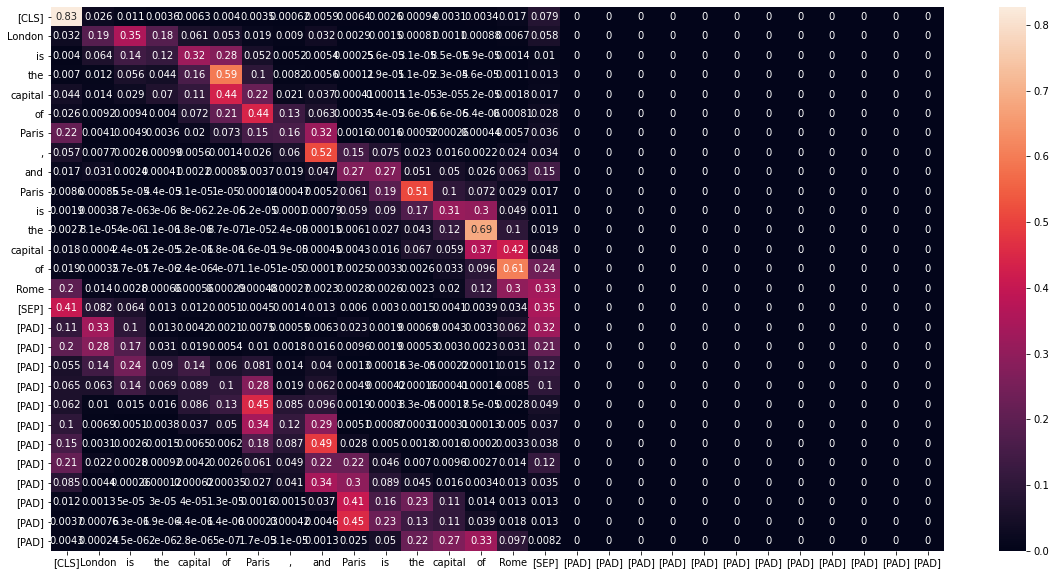

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.figure(figsize=(20, 10))

layer_id = 6
sent_id = 0
head_id = 11

tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][sent_id])
attention = pd.DataFrame(output.attentions[layer_id][sent_id][head_id].detach().numpy(), index=tokens, columns=tokens)

ax = sns.heatmap(attention, annot=True)

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=2)

dims = output[0].shape

vectors = output[0].detach().numpy().reshape(dims[0]*dims[1], 768)

output_2d = pca.fit_transform(vectors)

In [21]:
tokens = ' '.join([' '.join(tokenizer.tokenize(tokenizer.batch_decode(encoded_input['input_ids'])[i])) for i in range(len(texts))]).split()
' '.join(tokens)

'[CLS] London is the capital of Paris , and Paris is the capital of Rome [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [CLS] Paris est la commune la plus peu ##pl ##ée et la capitale de la France . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [CLS] Rom ist die Hauptstadt Italiens , Hauptort der Region La ##tium und historische Hauptstadt des R ##ö ##mischen Reich ##s und des Kirchen ##staat ##s . [SEP]'

In [22]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer.add_embedding(vectors, metadata=tokens)
writer.close()

In [23]:
import pandas as pd

output_2d = pd.DataFrame(output_2d, columns=['x', 'y'])
output_2d.shape

(84, 2)

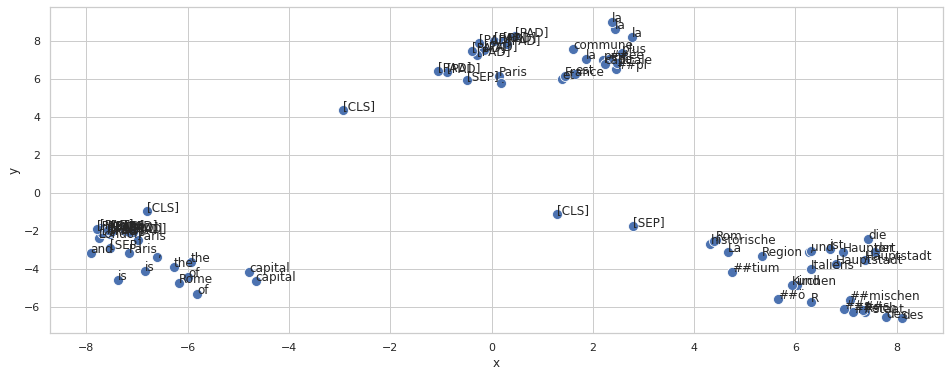

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

sns.set(style='whitegrid')
 
scatter = sns.scatterplot(data=output_2d, x='x', y='y', s=100)

for i in range(output_2d.shape[0]): scatter.annotate(tokens[i], (output_2d.x[i], output_2d.y[i]))

In [49]:
%load_ext tensorboard
%tensorboard --logdir /home/vagrant/project/logs/ --host 0.0.0.0 --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2211), started 0:23:12 ago. (Use '!kill 2211' to kill it.)

In [29]:
!ps -fA | grep tensorboard

vagrant   2176  2114  2 23:11 ?        00:00:07 [tensorboard] <defunct>
vagrant   2208  2114 10 23:16 pts/1    00:00:00 /bin/bash -c ps -fA | grep tensorboard
vagrant   2210  2208  0 23:16 pts/1    00:00:00 grep tensorboard


In [21]:
!kill 2176

### Char-level CNN

In [1]:
import torch
import torch.nn as nn

x = torch.tensor([[1, 1, 1, 1, 1], [2, 2, 2, 2, 2]], dtype=torch.float).unsqueeze(0)

cnn1d = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, bias=False)

print(cnn1d.weight)

cnn1d.forward(x)

Parameter containing:
tensor([[[-0.3827, -0.2062,  0.2024],
         [ 0.3437, -0.2075, -0.2740]],

        [[ 0.1739, -0.2319,  0.0831],
         [ 0.0636,  0.2296,  0.3052]]], requires_grad=True)


tensor([[[-0.6623, -0.6623, -0.6623],
         [ 1.2219,  1.2219,  1.2219]]], grad_fn=<SqueezeBackward1>)